In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler

from scipy.optimize import minimize
import psopy

import IPython.display as dp
import matplotlib.pyplot as plt
import seaborn as sns

dp.set_matplotlib_formats('retina')
sns.set_style('whitegrid')
sns.despine()

%matplotlib notebook

## Solver

This code initializes generator state variables and network terminal variables

In [2]:
def get_initial_values(P0, Q0, V0, angle0, theta0, Sn=2220, Vn=400, fn=60, Sb=100, Vb=400):
    """
    Initializes generator state vector `x` and network terminal variables vector `V`
    in machine base from given power flow values in system base and angle in radians.
    """
    
    # unpack parameters guess
    
    ws, ra, x1d, xd, xq, H, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, K0 = theta0
    
    # define transforms
    
    # vf_MB = vf * Vb / Vn
    wb = 2 * np.pi * fn
    S_SBtoMB = Sb / Sn
    V_MBtoSB = Vn / Vb
    I_MBtoSB = Sn * Vb / (Sb * Vn)
    Z_MBtoSB = Sb * Vn ** 2 / (Sn * Vb ** 2)
    
    # initialize stator quantitites
    
    p0 = P0 / Sb
    q0 = Q0 / Sb
    Vt0 = V0 * np.exp(1j * angle0)
    S0 = p0 - 1j * q0
    I0 = S0 / Vt0.conjugate()
    vr0 = Vt0.real
    vi0 = Vt0.imag
    ir0 = -I0.real
    ii0 = -I0.imag
    
    # initialize DQ-quantities
    
    w0 = 1
    delta0 = np.angle(Vt0 + (ra + 1j * xq) * Z_MBtoSB * I0)
    
    Vdq0 = Vt0 * (1 / V_MBtoSB) * np.exp(1j * (-delta0 + np.pi/2))
    Idq0 = I0 * (1 / I_MBtoSB) * np.exp(1j * (-delta0 + np.pi/2))
    
    vd0 = Vdq0.real
    vq0 = Vdq0.imag
    id0 = Idq0.real
    iq0 = Idq0.imag
    
    # initialize order 3
    
    e1q0 = vq0 + ra * iq0 + x1d * id0
    
    # initialize AVR
    
    v = np.abs(Vt0)
    vref = v
    vs0 = 0
    vm0 = v
    vf0 = (e1q0 + (xd - x1d) * id0) * V_MBtoSB
    vr0 = K0 * (1 - Tavr1 / Tavr2) * (vref + vs0 - vm0)
    
    # initialize PSS
    
    v20 = 0
    
    # constants
    
    pm = (vq0 + ra * iq0) * iq0 + (vd0 + ra * id0) * id0
    vsmin, vsmax = -0.2, 0.2
    vfmin, vfmax = -6.4, 7
    KD = 0
    Te = 1e-4
    
    # pack values
    
    x = np.array([delta0, w0, v20, vs0, vm0, vr0, vf0, e1q0])
    V = np.array([vd0, vq0, id0, iq0])
    c = np.array([pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, vs0, wb, KD, Te])
    
    return x, V, c

This code solves non-liear constraint optimization

In [3]:
def constraint_objective(x, xx, c, S, theta):
    delta, w, v2, vs, vm, vr, vf, e1q = xx
    vd, vq, id, iq = x
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb, KD, Te = c
    p, q = S
    ws, ra, x1d, xd, xq, H, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, K0 = theta
    vt = np.sqrt(vd ** 2 + vq ** 2)
    
    res = np.array([
        (x1d * xq + ra ** 2) * id - (xq * e1q - xq * vq - ra * vd),
        (x1d * xq + ra ** 2) * iq - (ra * e1q - ra * vq + x1d * vd),
        vd * id + vq * iq - p / 22.2,
        vq * id - vd * iq - q / 22.2
    ])
    
    return np.linalg.norm(res, 2) ** 2

def constraint_objective2(theta, x, xx, c, S):
    return constraint_objective(x, xx, c, S, theta)

def constraint_jacobian(x, xx, c, S, theta):
    delta, w, v2, vs, vm, vr, vf, e1q = xx
    vd, vq, id, iq = x
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb, KD, Te = c
    p, q = S
    ws, ra, x1d, xd, xq, H, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, K0 = theta
    vt = np.sqrt(vd ** 2 + vq ** 2)
    
    dif = 2 * np.array([
        (x1d * xq + ra ** 2) * id - (xq * e1q - xq * vq - ra * vd),
        (x1d * xq + ra ** 2) * iq - (ra * e1q - ra * vq + x1d * vd),
        vd * id + vq * iq - p / 22.2,
        vq * id - vd * iq - q / 22.2
    ])
    
    m = np.array([
        [ra, -x1d, id, -iq],
        [xq, ra, iq, id],
        [(x1d * xq + ra ** 2), 0, vd, vq],
        [0, (x1d * xq + ra ** 2), vq, -vd]
    ])
    
    return m @ dif

def constraint_jacobian2(theta, x, xx, c, S):
    delta, w, v2, vs, vm, vr, vf, e1q = xx
    vd, vq, id, iq = x
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb, KD, Te = c
    p, q = S
    ws, ra, x1d, xd, xq, H, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, K0 = theta
    vt = np.sqrt(vd ** 2 + vq ** 2)
    
    dif = 2 * np.array([
        (x1d * xq + ra ** 2) * id - (xq * e1q - xq * vq - ra * vd),
        (x1d * xq + ra ** 2) * iq - (ra * e1q - ra * vq + x1d * vd),
        vd * id + vq * iq - p / 22.2,
        vq * id - vd * iq - q / 22.2
    ])
    
    m = np.array([
        [0, 0, 0, 0],
        [2 * ra * id + vd, 2 * ra * iq - e1q + vq, 0, 0],
        [xq * id, xq * iq - vd, 0, 0],
        [0, 0, 0, 0],
        [x1d * id - e1q + vq, x1d * iq, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]
    ])
    
    return m @ dif

def constraint_solve(x, V, c, S, theta, threshold=1e-16):
    if constraint_objective(V, x, c, S, theta) < threshold:
        return V
    else:
        return minimize(constraint_objective,
                        x0=V,
                        args=(x, c, S, theta),
                        method='L-BFGS-B',
                        jac=constraint_jacobian, bounds=[(0., None)] * 4).x

This code defines transition from one time step to another

In [4]:
def transition(x, V, c, S, theta, tau=0.1, tol=1e-16):
    delta, w, v2, vs, vm, vr, vf, e1q = x
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb, KD, Te = c
    p, q = S
    ws, ra, x1d, xd, xq, H, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, K0 = theta
    
    Vnew = constraint_solve(x, V, c, S, theta, threshold=tol)
    vd, vq, id, iq = Vnew
    vt = np.sqrt(vd ** 2 + vq ** 2)
    
    xnew = x + tau * np.array([
        w - ws,
        ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H),
        Kw * ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H) - v2 / Tw,
        (Tpss1 * (Kw * ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id \
                             - KD * (w / ws - 1)) / (2 * H) - v2 / Tw) + v2 - vs) / Tpss2,
        (vt - vm) / Tr,
        (K0 * (1 - Tavr1 / Tavr2) * (vref + vs - vm) - vr) / Tavr2,
        ((vr + K0 * Tavr1 * (vref + vs - vm) / Tavr2 + vf0) * (1 + s0 * (vt / vm - 1)) - vf) / Te,
        (- e1q - (xd - x1d) * id + vf) / T1d0
    ])
    
    xnew[3] = max(vsmin, min(vsmax, xnew[3]))
    xnew[6] = max(vfmin, min(vfmax, xnew[6]))
    
    return xnew, Vnew

This code defines interface to solver in one function call

In [5]:
def solve(df, tau=0.1, tol=1e-16):
    theta0 = np.array([1., 0.003, 0.3, 1.81, 1.76,
                       3.5, 8., 10., 10., 0.05,
                       0.02, 0.015, 1., 1., 200])
    x0, V0, c = get_initial_values(P0=1997.9999999936396,
                                   Q0=967.9249699065775,
                                   V0=1.0,
                                   angle0=0.494677176989154,
                                   theta0=theta0)
    xs = [x0]
    Vs = [V0]
    for t in range(1, len(df)):
        xnew, Vnew = transition(xs[-1], Vs[-1], c, df[['p', 'q']].values[t], theta0, tau=tau, tol=tol)
        xs.append(xnew)
        Vs.append(Vnew)
        
    return xs, Vs

def solve_for_theta(injection, theta, tau=0.1, tol=1e-16):
    x0, V0, c = get_initial_values(P0=1997.9999999936396,
                                   Q0=967.9249699065775,
                                   V0=1.0,
                                   angle0=0.494677176989154,
                                   theta0=theta)
    xs = [x0]
    Vs = [V0]
    for t in range(1, injection.shape[0]):
        xnew, Vnew = transition(xs[-1], Vs[-1], c, injection[t], theta, tau=tau, tol=tol)
        xs.append(xnew)
        Vs.append(Vnew)
        
    return xs, Vs, c

## Learner

This code defines the ODE part and its derivative

In [6]:
def learning_f(x, v, c, theta):
    """
    Return f-function value
    """
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb, KD, Te = c
    ws, ra, x1d, xd, xq, H, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, K0 = theta
    delta, w, v2, vs, vm, vr, vf, e1q = x
    vd, vq, id, iq = v
    vt = np.sqrt(vd ** 2 + vq ** 2)
    
    return np.array([
        w - ws,
        ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H),
        Kw * ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H) - v2 / Tw,
        (Tpss1 * (Kw * ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id \
                             - KD * (w / ws - 1)) / (2 * H) - v2 / Tw) + v2 - vs) / Tpss2,
        (vt - vm) / Tr,
        (K0 * (1 - Tavr1 / Tavr2) * (vref + vs - vm) - vr) / Tavr2,
        ((vr + K0 * Tavr1 * (vref + vs - vm) / Tavr2 + vf0) * (1 + s0 * (vt / vm - 1)) - vf) / Te,
        (- e1q - (xd - x1d) * id + vf) / T1d0
    ])

def learning_grad_f(x, V, c, theta):
    """
    Retrun f-function gradient w.r.t. theta
    """
    delta, w, v2, vs, vm, vr, vf, e1q = x
    vd, vq, id, iq = V
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb, KD, Te = c
    ws, ra, x1d, xd, xq, H, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, K0 = theta
    vt = np.sqrt(vd ** 2 + vq ** 2)
    
    g1 = (pm - (vq + ra * iq) * iq - (vd + ra * id) * id + KD) / (2 * H)
    g2 = - ws * (iq ** 2 + id ** 2) / (2 * H)
    g3 = - ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H ** 2)
    g4 = ws * (w / ws - 1) / (2 * H)
    g5 = Kw * g1
    g6 = Kw * g2
    g7 = Kw * g3
    g8 = Kw * g4
    g9 = ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H)
    g10 = - v2 / (Tw ** 2)
    g11 = g5 * Tpss1 / Tpss2
    g12 = g6 * Tpss1 / Tpss2
    g13 = g7 * Tpss1 / Tpss2
    g14 = g8 * Tpss1 / Tpss2
    g15 = g9 * Tpss1 / Tpss2
    g16 = g10 * Tpss1 / Tpss2
    g17 = Kw * g9 / Tpss2
    g18 = - Kw * g9 * Tpss1 / (Tpss2 ** 2)
    g19 = - (vt - vm) / (Tr ** 2)
    g20 = - K0 * (vref + vs - vm) / (Tavr2 ** 2)
    g21 = - (K0 * (vref + vs - vm) - vr) / (Tavr2 ** 2) + 2 * K0 * Tavr1 * (vref + vs - vm) / (Tavr2 ** 3)
    g22 = (1 - Tavr1 / Tavr2) * (vref + vs - vm) / Tavr2
    g23 = K0 * (vref + vs - vm) * (1 + s0 * (vt / vm - 1)) / (Tavr2 * Te)
    g24 = - K0 * Tavr1 * (vref + vs - vm) * (1 + s0 * (vt / vm - 1)) / (Te * Tavr2 ** 2)
    g25 = - ((vr + K0 * Tavr1 * (vref + vs - vm) / Tavr2 + vf0) * (1 + s0 * (vt / vm - 1)) - vf) / (Te ** 2)
    g26 = Tavr1 * (vref + vs - vm) * (1 + s0 * (vt / vm - 1)) / (Te * Tavr2)
    g27 = id / T1d0
    g28 = - g27
    g29 = - (- e1q - (xd - x1d) * id + vf) / T1d0 ** 2
    
    jac = np.array([
        [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [g1, g2, 0, 0, 0, g3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [g5, g6, 0, 0, 0, g7, 0, g9, g10, 0, 0, 0, 0, 0, 0],
        [g11, g12, 0, 0, 0, g13, 0, g15, g16, g17, g18, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g19, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g20, g21, g22],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g23, g24, g26],
        [0, 0, g27, g28, 0, 0, g29, 0, 0, 0, 0, 0, 0, 0, 0]
    ])
    
    return jac

This code defines the gradient descent in ODEs part

In [7]:
def learning_objective(xs, vs, c, theta, tau, alpha, p=1000):
    """
    Objective to minimize. Sum over time of 2nd norm of error in ODEs.
    """
    dxs = [(xp - xm) / tau for xp, xm in zip(xs[1:], xs[:-1])]
    
    obj = [np.linalg.norm(learning_f(x, v, c, theta) - dx, ord=2) ** 2 \
           for x, v, dx in zip(xs[:-1:p], vs[:-1:p], dxs[::p])]
    idx = np.argmax(obj, axis=0)
    obj = obj[idx]
        
    return obj + alpha * np.linalg.norm(theta, ord=2) ** 2 / 2, idx

def learning_jacobian_once(x, V, dx, c, theta):
    """
    Objective Jacobian. One timestep.
    """
    jac = learning_grad_f(x, V, c, theta)
    F = learning_f(x, V, c, theta) - dx
    
    return (F @ jac).flatten()
    
def learning_jacobian(xs, vs, c, theta, tau, alpha, idx, p=1000):
    """
    Objective Jacobian. Decomposes in time.
    """
    dxs = [(xp - xm) / tau for xp, xm in zip(xs[1:], xs[:-1])]
    x, v, dx = list(zip(xs[:-1:p], vs[:-1:p], dxs[::p]))[idx]
    jac = 2 * learning_jacobian_once(x, v, dx, c, theta)
        
    return jac + alpha * theta

This code solves initial parameter guess optimization

In [8]:
def learning_theta_objective(theta):
    x, v, c = get_initial_values(P0=1997.9999999936396,
                                 Q0=967.9249699065775,
                                 V0=1.0,
                                 angle0=0.494677176989154,
                                 theta0=theta)
    s = np.array([19.979999999936396, 9.679249699065775])
    
    f = learning_f(x, v, c, theta)
    
    return constraint_objective2(theta, v, x, c, s) + np.linalg.norm(f, ord=2) ** 2

def learning_theta_guess(theta, threshold):
    if learning_theta_objective(theta) < threshold:
        return theta
    else:
        return minimize(learning_theta_objective,
                        x0=theta, bounds=[(1e-16, None)] * 15).x

This code solves constraint (algebraic part) optimization

In [9]:
def learning_constraint_objective(theta, xs, vs, ss, c, theta0, lbd, mu, p=1000):
    """
    Constraint to project onto.
    """
    diff = np.linalg.norm(theta - theta0, ord=2) ** 2 / 2
    g_constraint = np.mean([constraint_objective2(theta, v, x, c, s) \
                            for x, v, s in zip(xs[::p], vs[::p], ss[::p])], axis=0)
    f_constraint = np.linalg.norm(learning_f(xs[0], vs[0], c, theta), ord=2) ** 2 / 2
    return diff + lbd * g_constraint + mu * f_constraint
    
def learning_constraint_jacobian(theta, xs, vs, ss, c, theta0, lbd, mu, p=1000):
    """
    Constraint jacobian.
    """
    diff = theta - theta0
    g_constraint = np.mean([constraint_jacobian2(theta, v, x, c, s) \
                            for x, v, s in zip(xs[::p], vs[::p], ss[::p])], axis=0)
    f_constraint = 2 * (learning_f(xs[0], vs[0], c, theta) @ learning_grad_f(xs[0], vs[0], c, theta)).flatten()
    return diff + lbd * g_constraint + mu * f_constraint

def learning_constraint_project(xs, vs, ss, c, theta, lbd, mu, threshold):
    if learning_constraint_objective(theta, xs, vs, ss, c, theta, lbd, mu) < threshold:
        return theta
    else:
        return minimize(learning_constraint_objective,
                        x0=theta,
                        args=(xs, vs, ss, c, theta, lbd, mu),
                        method='L-BFGS-B',
                        jac=learning_constraint_jacobian, bounds=[(0., None)] * 15).x

This code defines an interface for learner in one function call

In [10]:
def learning_step(theta, step, jac, projector):
    """
    Performs one gradient update and projection onto feasible region if necessary.
    """
    return projector(theta - step * jac)

def learning_load(fname):
    df = pd.read_csv(fname).drop_duplicates('t').drop(['t'], axis=1)
    df.phi = df.phi * np.pi / 180
    return df[['p', 'q']].values, df[['v', 'phi']].values
    
def learning(injections, folder, theta_true,
             stepsize=None, eta=1., steps=1e2,
             eps=1e-3, tau=1e-4, tol=1e-16,
             lbd=1e3, alpha=1.0,
             nu=1e3, mu=1e3):
    """
    Performs optimization via projected gradient descent or augmentated Jacobain.
    """
    scaler = StandardScaler()
    scaler.fit(theta_true.reshape((1, -1)))
    Theta = scaler.transform(learning_theta_guess(np.abs(np.random.randn(15) * 10), tol))
    iname = np.random.choice(injections)
    injection, reference = learning_load(os.path.join(folder, iname))
    Xs, Vs, C = solve_for_theta(injection, scaler.inverse_transform(Theta), tau, tol)
    step_n = 0
    
    lo = lambda xs, vs, ss, c, theta: learning_objective(xs, vs, c, theta, tau, alpha)
    lj = lambda xs, vs, ss, c, theta, i: learning_jacobian(xs, vs, c, theta, tau, alpha, i)
    lc = lambda xs, vs, ss, c, theta: learning_constraint_project(xs, vs, ss, c, theta, nu, mu, tol)
    lobj, lidx = lo(Xs, Vs, injection, C, Theta)
    while step_n < steps and lobj > eps:
        step = eta * (stepsize(step_n) if stepsize is not None else 1.)
        jac = lj(Xs, Vs, injection, C, Theta, lidx)
        jac = np.clip(jac, -1e-3, 1e3)
        proj = lambda theta: lc(Xs, Vs, injection, C, theta)
        Theta = learning_step(Theta, step, jac, proj)
        Xs, Vs, C = solve_for_theta(injection, scaler.inverse_transform(Theta), tau, tol)
        lobj, lidx = lo(Xs, Vs, injection, C, Theta)
        if reference is not None and step_n % 50 == 0:
            VRs = np.array([vv[0] * np.sin(xx[0]) + vv[1] * np.cos(xx[0]) for vv, xx in zip(Vs, Xs)])
            VIs = np.array([- vv[1] * np.sin(xx[0]) + vv[0] * np.cos(xx[0]) for vv, xx in zip(Vs, Xs)])
            pred = np.array([[np.sqrt(vr ** 2 + vi ** 2) for vr, vi in zip(VRs, VIs)],
                             [np.arctan2(vi, vr) for vr, vi in zip(VRs, VIs)]]).T
            fig, ax = plt.subplots(1, 2, figsize=(20, 10))
            ax[0].plot(pred[:, 0], label='predicted')
            ax[0].plot(reference[:, 0], label='true')
            ax[0].legend()
            ax[0].set_title('V')
            ax[1].plot(pred[:, 1], label='predicted')
            ax[1].plot(reference[:, 1], label='true')
            ax[1].legend()
            ax[1].set_title('Phi')
            plt.savefig('saved_fig/epoch-%.4d.png' % step_n)
            plt.show()
            nrmse = np.sqrt(np.mean(np.linalg.norm(reference-pred, ord=2, axis=1)) ** 2)
            nrmse /= np.sqrt(np.mean(np.linalg.norm(reference, ord=2, axis=1) ** 2))
            dist = np.linalg.norm(scaler.inverse_transform(Theta)-theta_true, ord=2)
            print('Iteration %4d' % step_n,  'objective val %.3e' % lobj,
                  'solution NRMSE %.3e' % nrmse,
                  'l2 distance to solution %.3e' % dist)
        iname = np.random.choice(injections)
        injection, reference = learning_load(os.path.join(folder, iname))
        step_n += 1
    return Theta

In [13]:
from sklearn.preprocessing import MinMaxScaler

class Learner():
    def __init__(self, injections, folder, theta_true, stepsize=None, eta=1., steps=1e2,
                 eps=1e-3, tau=1e-4, tol=1e-16, lbd=1e3, alpha=1.0, nu=1e3, mu=1e3):
        self.injections = [os.path.join(folder, fname) for fname in injections]
        self.theta_true = theta_true
        self.stepsize = stepsize
        self.steps = steps
        self.eta = eta
        self.eps = eps
        self.tau = tau
        self.tol = tol
        self.lbd = lbd
        self.alpha = alpha
        self.nu = nu
        self.mu = mu
        
        self.scaler = MinMaxScaler()
        self.scaler.fit(self.theta_true.reshape((1, -1)))
        self.theta = None
        
        self.lo = lambda xs, vs, ss, c, y: learning_objective(xs, vs, c, self.inverse_transform(y),
                                                              self.tau, self.alpha)
        self.lj = lambda xs, vs, ss, c, y, i: learning_jacobian(xs, vs, c, self.inverse_transform(y),
                                                                self.tau, self.alpha, i)
        self.lc = lambda xs, vs, ss, c, y: self.transform(learning_constraint_project(xs, vs, ss, c,
                                                                                      self.inverse_transform(y),
                                                                                      self.nu, self.mu, self.tol))

    def transform(self, x):
        return x / np.array([1, 1e-3, 1e-1, 1, 1, 1, 1, 10, 10, 1e-2, 1e-2, 1e-2, 1, 1, 1e2])
    
    def inverse_transform(self, x):
        return x * np.array([1, 1e-3, 1e-1, 1, 1, 1, 1, 10, 10, 1e-2, 1e-2, 1e-2, 1, 1, 1e2])
        
    def step(self, injection, i, Xs, Vs, C, lobj, lidx):
        step = self.eta * (self.stepsize(i) if self.stepsize is not None else 1.)
        jac = self.lj(Xs, Vs, injection, C, self.theta, lidx)
        jac = np.clip(jac, -1e3, 1e3)
        proj = lambda y: self.lc(Xs, Vs, injection, C, y)
        self.theta = learning_step(self.theta, step, jac, proj)
        Xs, Vs, C = solve_for_theta(injection, self.inverse_transform(self.theta), self.tau, self.tol)
        lobj, lidx = self.lo(Xs, Vs, injection, C, self.theta)
        return Xs, Vs, C, lobj, lidx
        
    def fit(self, theta0=None):
        if theta0 is None:
            self.theta = learning_theta_guess(np.abs(np.random.randn(15) * 10), tol)
            self.theta = self.transform(self.theta)
        else:
            self.theta = self.transform(theta0)
        injection, reference = learning_load(np.random.choice(self.injections))
        Xs, Vs, C = solve_for_theta(injection, self.inverse_transform(self.theta), self.tau, self.tol)
        lobj, lidx = self.lo(Xs, Vs, injection, C, self.theta)
        for i in range(self.steps):
            Xs, Vs, C, lobj, lidx = self.step(injection, i, Xs, Vs, C, lobj, lidx)
            if i % 50 == 0:
                VRs = np.array([vv[0] * np.sin(xx[0]) + vv[1] * np.cos(xx[0]) for vv, xx in zip(Vs, Xs)])
                VIs = np.array([- vv[1] * np.sin(xx[0]) + vv[0] * np.cos(xx[0]) for vv, xx in zip(Vs, Xs)])
                pred = np.array([[np.sqrt(vr ** 2 + vi ** 2) for vr, vi in zip(VRs, VIs)],
                                 [np.arctan2(vi, vr) for vr, vi in zip(VRs, VIs)]]).T
                plt.clf()
                fig, ax = plt.subplots(1, 2, figsize=(20, 10))
                ax[0].plot(pred[:, 0], label='predicted')
                ax[0].plot(reference[:, 0], label='true')
                ax[0].legend()
                ax[0].set_title('V')
                ax[1].plot(pred[:, 1], label='predicted')
                ax[1].plot(reference[:, 1], label='true')
                ax[1].legend()
                ax[1].set_title('Phi')
                fig.savefig('saved_fig/epoch-%.4d.png' % i)
                plt.close()
                nrmse = np.sqrt(np.mean(np.linalg.norm(reference-pred, ord=2, axis=1)) ** 2)
                nrmse /= np.sqrt(np.mean(np.linalg.norm(reference, ord=2, axis=1) ** 2))
                dist = np.linalg.norm(self.inverse_transform(self.theta)-theta_true, ord=2)
                print('Iteration %4d' % i,  'objective val %.3e' % lobj,
                      'solution NRMSE %.3e' % nrmse,
                      'l2 distance to solution %.3e' % dist)
            injection, reference = learning_load(np.random.choice(self.injections))

## Testing

In [11]:
df = pd.read_csv('./exportedVariables.csv')

In [12]:
df.head()

,time,machine3.gen3.P,machine3.gen3.Q,machine3.gen3.v,machine3.gen3.anglev
0,0.0000,19.98,9.67925,1.0,28.3429
1,0.0001,19.98,9.67925,1.0,28.3429
2,0.0002,19.98,9.67925,1.0,28.3429
3,0.0003,19.98,9.67925,1.0,28.3429
4,0.0004,19.98,9.67925,1.0,28.3429


In [13]:
df = df.drop_duplicates('time')

In [14]:
df = df.drop(['time'], axis=1)

In [15]:
df.columns = ['p', 'q', 'v', 'phi']

In [16]:
df.phi = df.phi * np.pi / 180

### Testing solver

In [ ]:
x, v = solve(df, tau=0.0001)

In [ ]:
Vs = [np.sqrt(xx[0] ** 2 + xx[1] ** 2) for xx in v]

In [ ]:
phis = [np.arctan2(xx[1], xx[0]) for xx in v]

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(Vs, label='predicted')
plt.plot(df.v.values, label='true')
# plt.plot(np.abs(df.v.values - Vs))
plt.legend()

In [ ]:
plt.plot(phis, label='predicted')
plt.plot(df.phi.values, label='true')
# plt.plot(np.abs(df.v.values - Vs))
plt.legend()

In [ ]:
for t, line in enumerate(np.hstack([np.array(x), np.array(v), df[['p', 'q']].values])):
    print(t / 10, line)
    # delta, w, v2, vs, vm, vr, vf, e1q, vd, vq, id, iq, p, q

### Testing learner

In [ ]:
old_settings = np.seterr(all='raise')

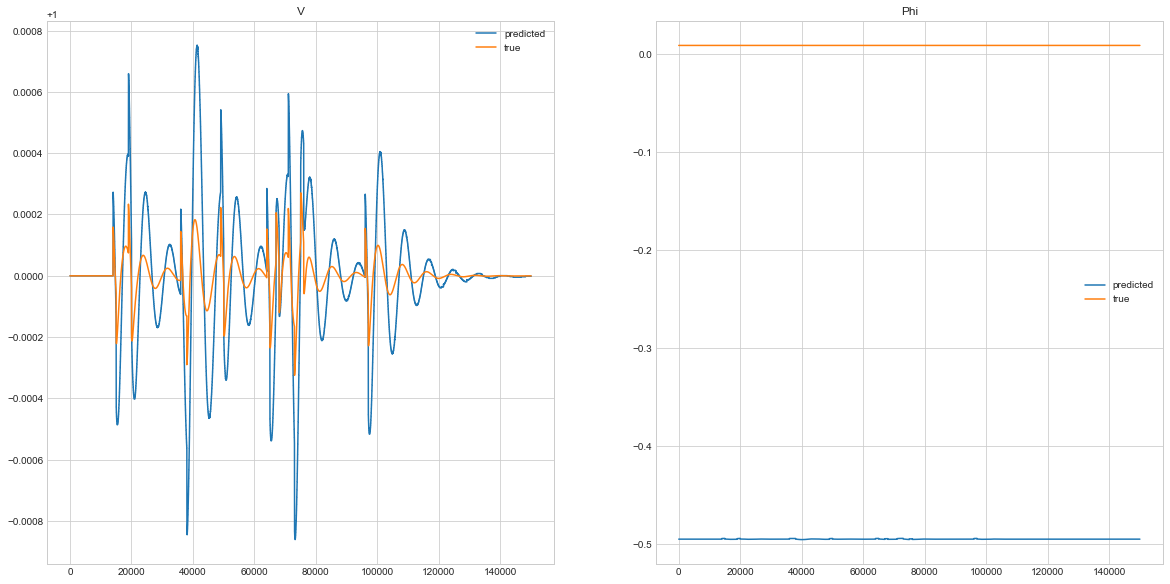

Iteration    0 objective val 1.610e-07 solution NRMSE 5.033e-01


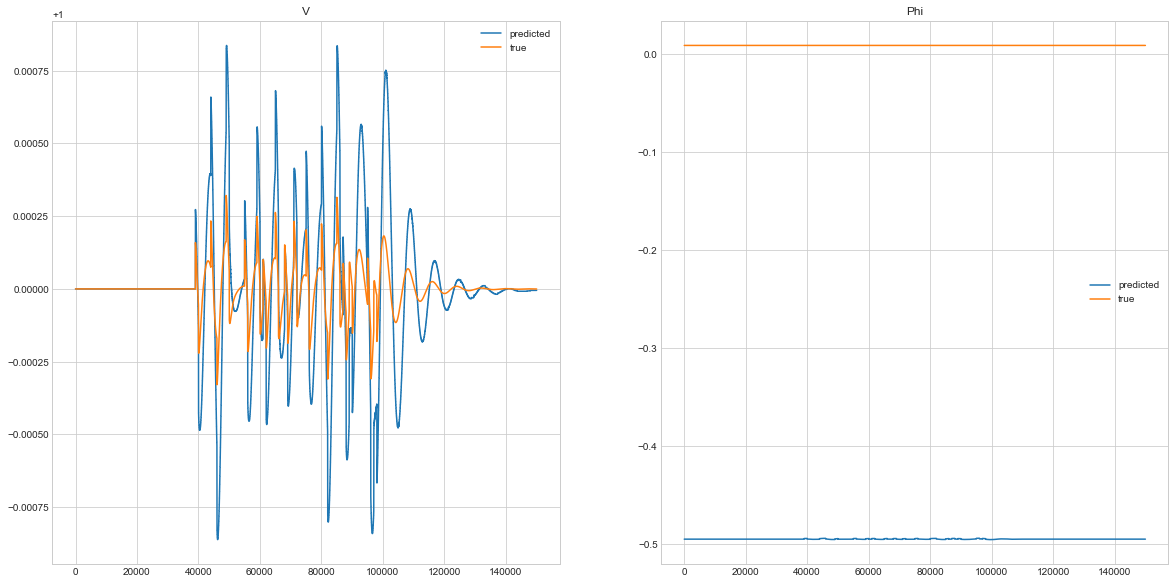

Iteration   50 objective val 1.292e-07 solution NRMSE 5.032e-01


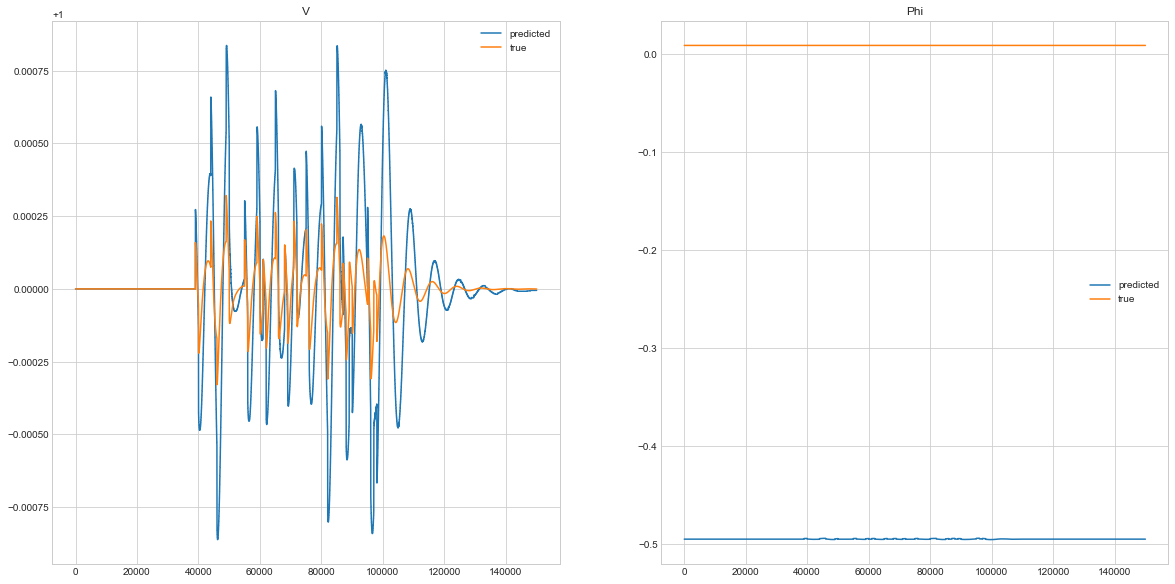

Iteration  100 objective val 1.292e-07 solution NRMSE 5.032e-01


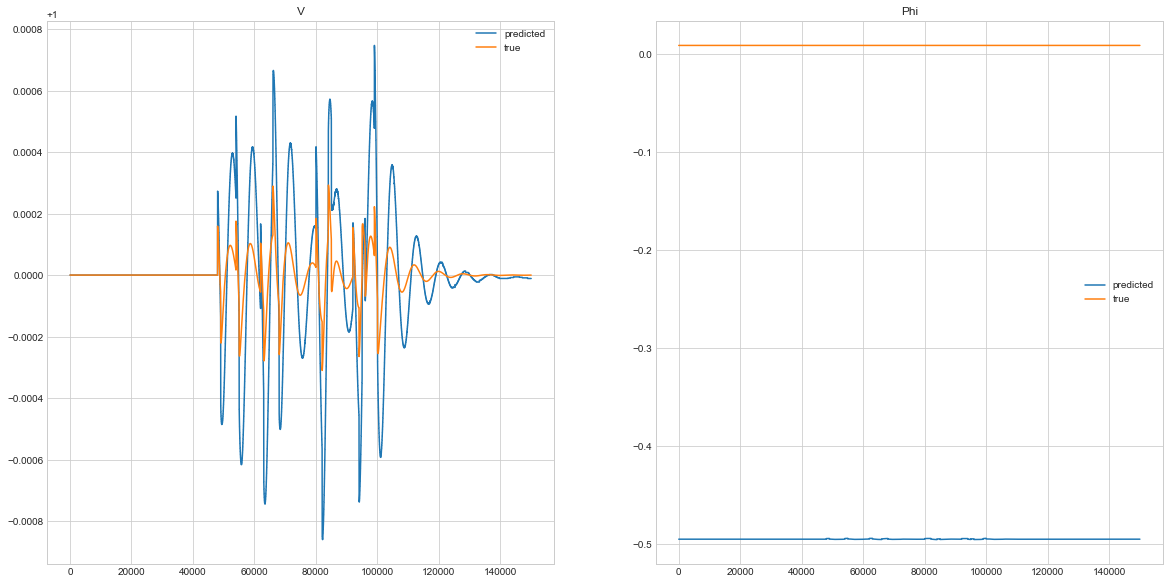

Iteration  150 objective val 7.557e-08 solution NRMSE 5.033e-01


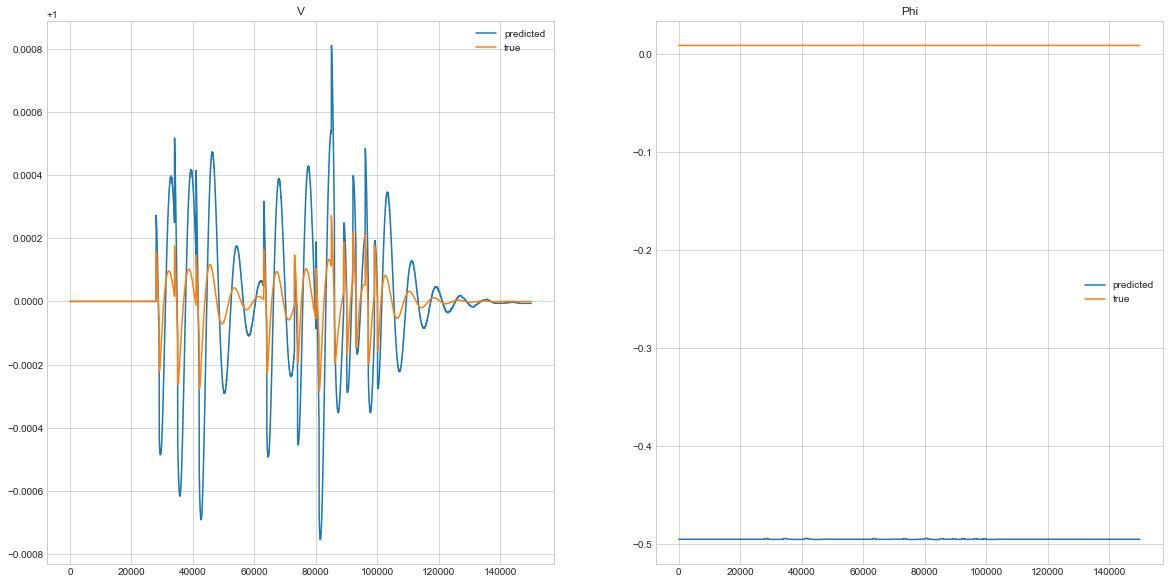

Iteration  200 objective val 4.593e-08 solution NRMSE 5.033e-01


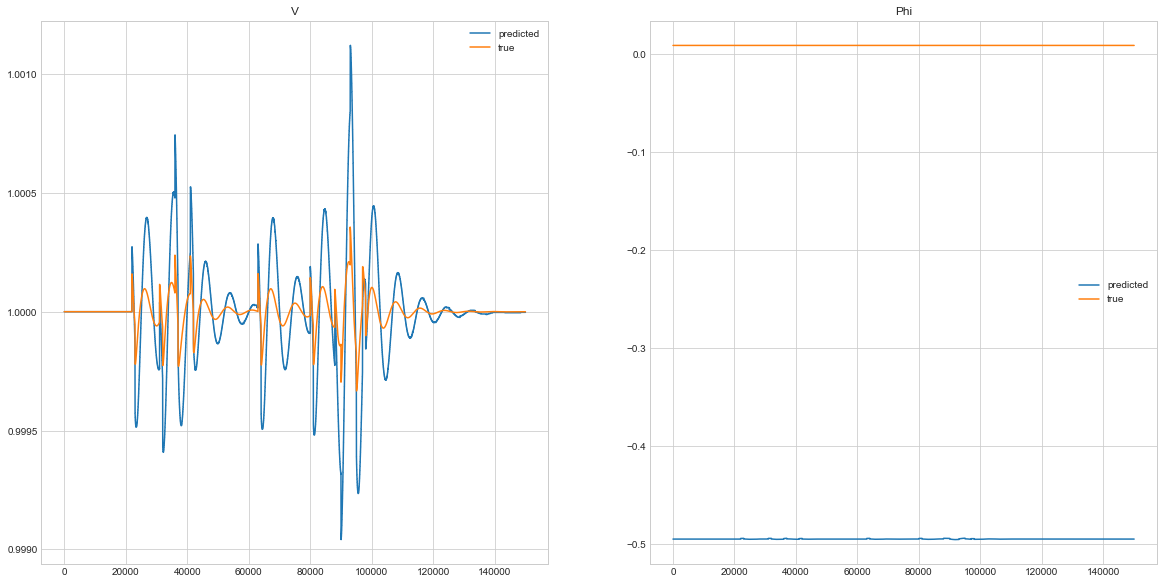

Iteration  250 objective val 6.831e-08 solution NRMSE 5.033e-01


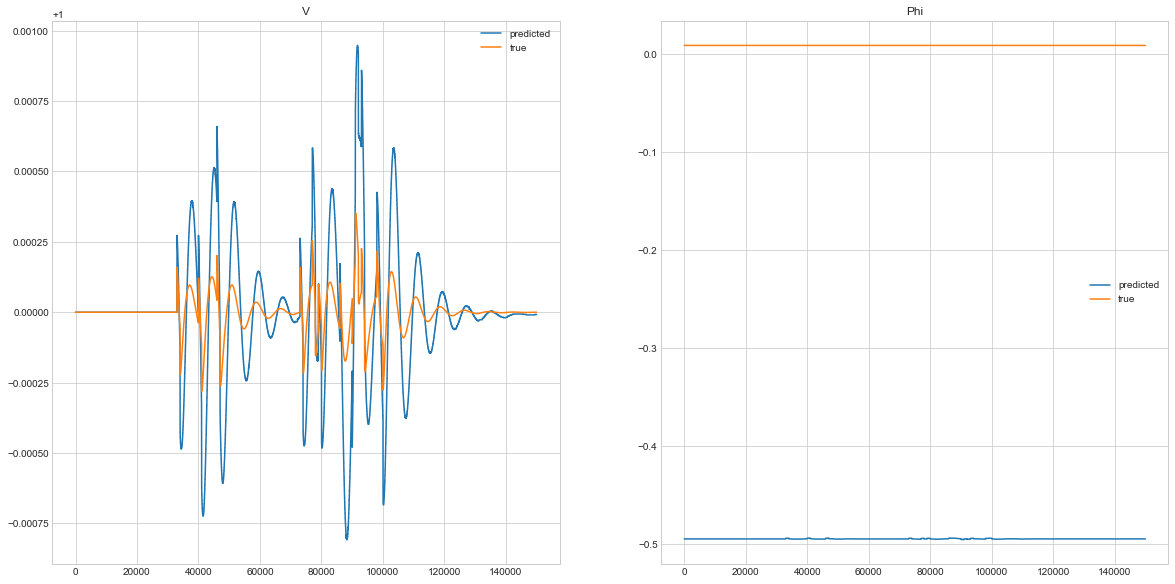

Iteration  300 objective val 8.078e-08 solution NRMSE 5.032e-01


In [ ]:
theta_pred = learning(injections=[xx for xx in os.listdir('data_simple/std_params/R_e1') if xx != '.DS_Store'],
                      folder='data_simple/std_params/R_e1',
                      stepsize=lambda k: max(1e-3, 1 / (1 + k % 100)), steps=10000,
                      alpha=0, eps=1e-16, nu=1e3, mu=1e3)

In [102]:
x, v, c = solve_for_theta(df[['p', 'q']].values, theta0, tau=0.0001)

In [103]:
Vs = [np.sqrt(xx[0] ** 2 + xx[1] ** 2) for xx in v]

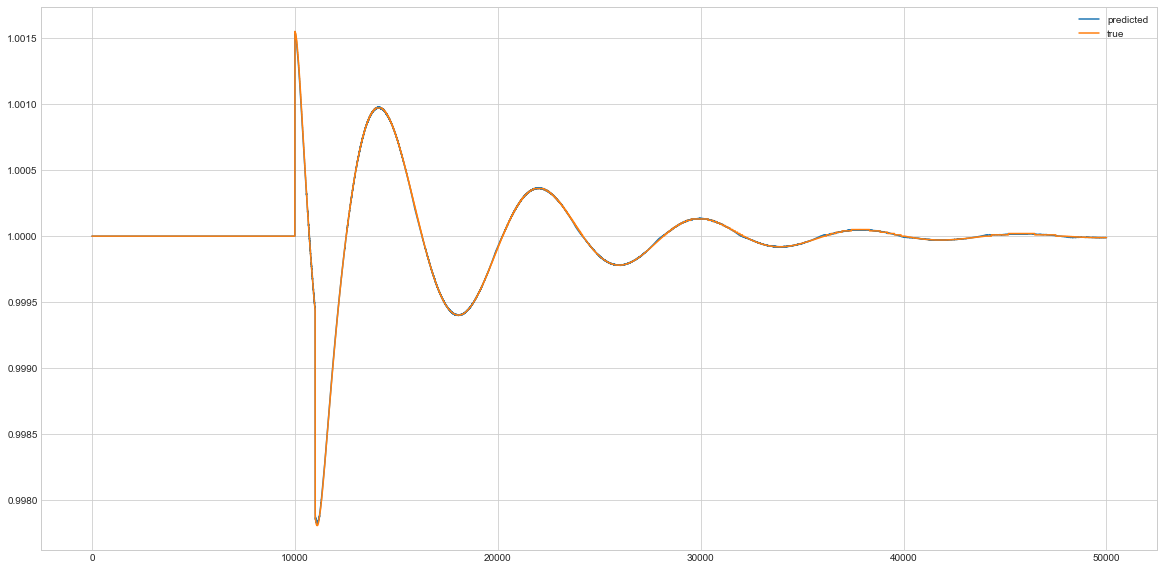

In [104]:
plt.figure(figsize=(20,10))
plt.plot(Vs, label='predicted')
plt.plot(df.v.values, label='true')
# plt.plot(np.abs(df.v.values - Vs))
plt.legend()

In [ ]:
np.seterr(**old_settings)

In [16]:
theta_true = np.array([1., 0.003, 0.3, 1.81, 1.76,
                       3.5, 8., 10., 10., 0.05,
                       0.02, 0.015, 1., 1., 200])

## Constrained bayesian learner

In [17]:
# ws, ra, x1d, xd, xq, H, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, K0 = theta
# 0   1   2    3   4   5  6     7   8   9      10     11  12     13     14
# delta, w, v2, vs, vm, vr, vf, e1q = x
# 0      1  2   3   4   5   6   7
# vd, vq, id, iq = V
# 0   1   2   3
# pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb, KD, Te = c
# 0   1      2      3      4      5     6    7   8   9   10

In [33]:
injection = df[['p', 'q']].values
x0 = np.array([learning_theta_guess(np.abs(np.random.rand(15) * 10), 1e-16) for _ in range(100)])
Xs, Vs, C = solve_for_theta(injection, x0[0], 1e-4, 1e-16)

In [34]:
pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb, KD, Te = C
delta, w, v2, vs, vm, vr, vf, e1q = Xs[0]
vt = np.sqrt(Vs[0][0] ** 2 + Vs[0][1] ** 2)

fun = lambda x: learning_objective(Xs, Vs, C, x, 1e-4, 0)[0]
cons = ({'type': 'eq', 'fun': lambda x: w - x[0]},
        {'type': 'eq', 'fun': lambda x: x[0] * (pm - (vq + x[1] * iq) * iq - (vd + x[1] * id) * id -\
                                                KD * (w / x[0] - 1)) / (2 * x[5])},
        {'type': 'eq', 'fun': lambda x: x[7] * x[0] * (pm - (vq + x[1] * iq) * iq - (vd + x[1] * id) * id \
                                                       - KD * (w / x[0] - 1)) / (2 * x[5]) - v2 / x[8]},
        {'type': 'eq', 'fun': lambda x: (x[9] * (x[7] * x[0] * (pm - (vq + x[1] * iq) * iq - (vd + x[1] * id) * id \
                                                                - KD * (w / x[1] - 1)) / (2 * x[5]) - v2 / x[8]) + \
                                         v2 - vs) / x[10]},
        {'type': 'eq', 'fun': lambda x: (vt - vm) / x[11]},
        {'type': 'eq', 'fun': lambda x: (x[14] * (1 - x[12] / x[13]) * (vref + vs - vm) - vr) / x[13]},
        {'type': 'eq', 'fun': lambda x: ((vr + x[14] * x[12] * (vref + vs - vm) / x[13] + vf0) * \
                                         (1 + s0 * (vt / vm - 1)) - vf) / Te},
        {'type': 'eq', 'fun': lambda x: (- e1q - (x[3] - x[2]) * id + vf) / x[6]},)

for (delta, w, v2, vs, vm, vr, vf, e1q), (vd, vq, id, iq), (p, q) in zip(Xs[::1000], Vs[::1000], injection[::1000]):
    cons += ({'type': 'eq', 'fun': lambda x: (x[2] * x[4] + x[1] ** 2) * id - (x[4] * e1q - x[4] * vq - x[1] * vd)}, 
             {'type': 'eq', 'fun': lambda x: (x[2] * x[4] + x[1] ** 2) * iq - (x[1] * e1q - x[1] * vq + x[2] * vd)},
             {'type': 'eq', 'fun': lambda x: vd * id + vq * iq - p / 22.2},
             {'type': 'eq', 'fun': lambda x: vq * id - vd * iq - q / 22.2})

In [35]:
def callback(x):
    VRs = np.array([vv[0] * np.sin(xx[0]) + vv[1] * np.cos(xx[0]) for vv, xx in zip(Vs, Xs)])
    VIs = np.array([- vv[1] * np.sin(xx[0]) + vv[0] * np.cos(xx[0]) for vv, xx in zip(Vs, Xs)])
    pred = np.array([np.sqrt(vr ** 2 + vi ** 2) for vr, vi in zip(VRs, VIs)])
    nrmse = np.sqrt(np.mean((df['v'].values-pred) ** 2))
    nrmse /= np.sqrt(np.mean(df['v'].values ** 2))
    print(nrmse)

In [36]:
res = psopy.minimize(fun, x0, constraints=cons, callback=callback)

0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415444587
0.6439494415

ValueError: operands could not be broadcast together with shapes (15,) (100,) 

## Unconstrained bayesian learner

In [12]:
import pyswarms as ps

In [13]:
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = ps.single.GlobalBestPSO(100, 15, options)

In [21]:
def opt_fun(x):
    inj, _ = learning_load('data_simple/std_params/R_e1/data_10.csv')
    x = sc.inverse_transform(x.reshape((1, -1))).flatten()
    Xs, Vs, C = solve_for_theta(inj, x, tau=1e-4)
    l_obj = learning_objective(Xs, Vs, C, x, 1e-4, 0)[0]
    g_constraint = np.mean([constraint_objective2(x, v, xx, C, s) \
                            for xx, v, s in zip(Xs[::1000], Vs[::1000], inj[::1000])], axis=0)
    f_constraint = np.linalg.norm(learning_f(Xs[0], Vs[0], C, x), ord=2) ** 2 / 2
    return l_obj + 1e3 * g_constraint + 1e3 * f_constraint

In [23]:
best_cost, best_pos = optimizer.optimize(lambda x: np.apply_along_axis(opt_fun, 1, x), 1, fast=True)

2019-03-17 12:24:54,483 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



pyswarms.single.global_best:   0%|          |0/1


pyswarms.single.global_best:   0%|          |0/1, best_cost=0.000726


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=0.000726


2019-03-17 14:02:59,272 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0007260306203419471, best pos: [-1.20459082e-03  1.37767314e+00  1.61599798e+00  8.31136909e-01
  6.25382071e-01  1.45981189e+00  1.89513689e+00  3.40508896e-01
  1.25236183e+00  4.59899213e-01  5.93612167e-01  2.21840238e+00
  1.92801653e+00  4.84017611e-01  8.94225223e-01]


In [12]:
theta0 = np.array([0.99879541, 1.38067314, 1.91599798, 2.64113691, 2.38538207, 4.95981189,
                   9.89513689, 10.3405089, 11.25236183, 0.50989921, 0.61361217, 2.23340238,
                   2.92801653, 1.48401761, 200.89422522])

In [24]:
theta0 = sc.inverse_transform(best_pos.reshape((1, -1))).flatten()

In [25]:
print(theta0)

[  0.99879541   1.38067314   1.91599798   2.64113691   2.38538207
   4.95981189   9.89513689  10.3405089   11.25236183   0.50989921
   0.61361217   2.23340238   2.92801653   1.48401761 200.89422522]


In [26]:
for pred, true in zip(theta0.flatten(), theta_true):
    print('%.3f %.3f' % (pred, true))

0.999 1.000
1.381 0.003
1.916 0.300
2.641 1.810
2.385 1.760
4.960 3.500
9.895 8.000
10.341 10.000
11.252 10.000
0.510 0.050
0.614 0.020
2.233 0.015
2.928 1.000
1.484 1.000
200.894 200.000


In [16]:
sc = StandardScaler()

In [18]:
sc.fit(theta_true.reshape((1, -1)))

StandardScaler(copy=True, with_mean=True, with_std=True)

## GD learner with Bayesian init

In [17]:
lrn = Learner(injections=[xx for xx in os.listdir('data_simple/std_params/R_e1') if xx != '.DS_Store'],
              folder='data_simple/std_params/R_e1', theta_true=theta_true,
              stepsize=lambda k: max(1e-5, 1 / (1 + k % 100)), eta=1e-3, steps=10000,
              alpha=0, eps=1e-16, nu=1e3, mu=1e3)

In [18]:
lrn.fit(theta0=theta0)

Iteration    0 objective val 3.829e-10 solution NRMSE 5.032e-01 l2 distance to solution 4.820e+00
Iteration   50 objective val 1.889e-09 solution NRMSE 5.032e-01 l2 distance to solution 4.820e+00
Iteration  100 objective val 4.996e-09 solution NRMSE 5.032e-01 l2 distance to solution 4.820e+00
Iteration  150 objective val 1.253e-08 solution NRMSE 5.032e-01 l2 distance to solution 4.820e+00
Iteration  200 objective val 6.428e-10 solution NRMSE 5.032e-01 l2 distance to solution 4.820e+00
Iteration  250 objective val 1.677e-10 solution NRMSE 5.031e-01 l2 distance to solution 4.820e+00
Iteration  300 objective val 5.934e-10 solution NRMSE 5.032e-01 l2 distance to solution 4.820e+00
Iteration  350 objective val 1.927e-09 solution NRMSE 5.032e-01 l2 distance to solution 4.820e+00
Iteration  400 objective val 9.027e-10 solution NRMSE 5.032e-01 l2 distance to solution 4.820e+00
Iteration  450 objective val 2.326e-09 solution NRMSE 5.032e-01 l2 distance to solution 4.820e+00
Iteration  500 objec

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [42]:
lrn.transform(lrn.theta)

array([  1.00000001,   1.3806919 ,   1.91596862,   2.64113589,
         2.38540844,   4.95981174,   9.89513694,  10.34050897,
        11.25236183,   0.50989984,   0.61361165,   2.23340242,
         2.92801653,   1.48401761, 200.89422522])

In [38]:
theta0

array([  0.99879541,   1.38067314,   1.91599798,   2.64113691,
         2.38538207,   4.95981189,   9.89513689,  10.3405089 ,
        11.25236183,   0.50989921,   0.61361217,   2.23340238,
         2.92801653,   1.48401761, 200.89422522])